In [71]:
import pandas as pd
import numpy as np 
import boto3 
import pymssql 
import pymysql
import json 
import warnings 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 70
plt.style.use('ggplot')

## **ODIN MSSQL Backend** 

In [3]:
mssql_secrets: 'MSSQL' = boto3.client("secretsmanager")
user, passwd, host, db, = list(json.loads(mssql_secrets.get_secret_value(SecretId='mssql_db_analysis').get('SecretString')).values())
con: 'MSSQL' = pymssql.connect(user=user, password=passwd, database=db, host=host)
con.autocommit(True)

cust_func: 'DataFrame' = pd.read_sql("SELECT definition FROM sys.sql_modules", con=con) # T-SQL custom functions

## **ODIN MySQL Backend**

In [32]:
user1, passwd1, host1, db1, _ = list(json.loads(mssql_secrets.get_secret_value(SecretId='mysql_develoment').get('SecretString')).values())
con1: 'MSSQL' = pymysql.connect(user=user1, password=passwd1, database=db1, host=host1)
con1.autocommit(True)

## **Crude Oils Production in CA**

In [45]:
prod_ca: 'DataFrame' = pd.read_sql("SELECT * FROM productions_california", con=con1)
prod_ca.head()

,level_0,index,period,duoarea,area_name,product,product_name,process,process_name,series,series_description,value,units
0,0,0,2023-08,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,306,MBBL/D
1,1,1,2023-07,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,308,MBBL/D
2,2,2,2023-06,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,311,MBBL/D
3,3,3,2023-05,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,310,MBBL/D
4,4,4,2023-04,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,310,MBBL/D


## **Weekly Pricing in CA by `EIA.gov`**

In [165]:
pricing_ca: 'DataFrame' = pd.read_sql("SELECT * FROM pricing_california", con=con1)
pricing_ca.drop(['level_0'], inplace=True, axis=1)
pricing_ca['period'] = pd.to_datetime(pricing_ca['period'])
pricing_ca['month'] = pricing_ca['period'].apply(lambda row: row.month) 
pricing_ca['year'] = pricing_ca['period'].apply(lambda row: row.year) 
pricing_ca.head()

,index,period,duoarea,area_name,product,product_name,process,process_name,series,series_description,value,units,month,year
0,0,2023-11-20,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.144,$/GAL,11,2023
1,1,2023-11-13,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.238,$/GAL,11,2023
2,2,2023-11-06,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.309,$/GAL,11,2023
3,3,2023-10-30,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.415,$/GAL,10,2023
4,4,2023-10-23,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.515,$/GAL,10,2023


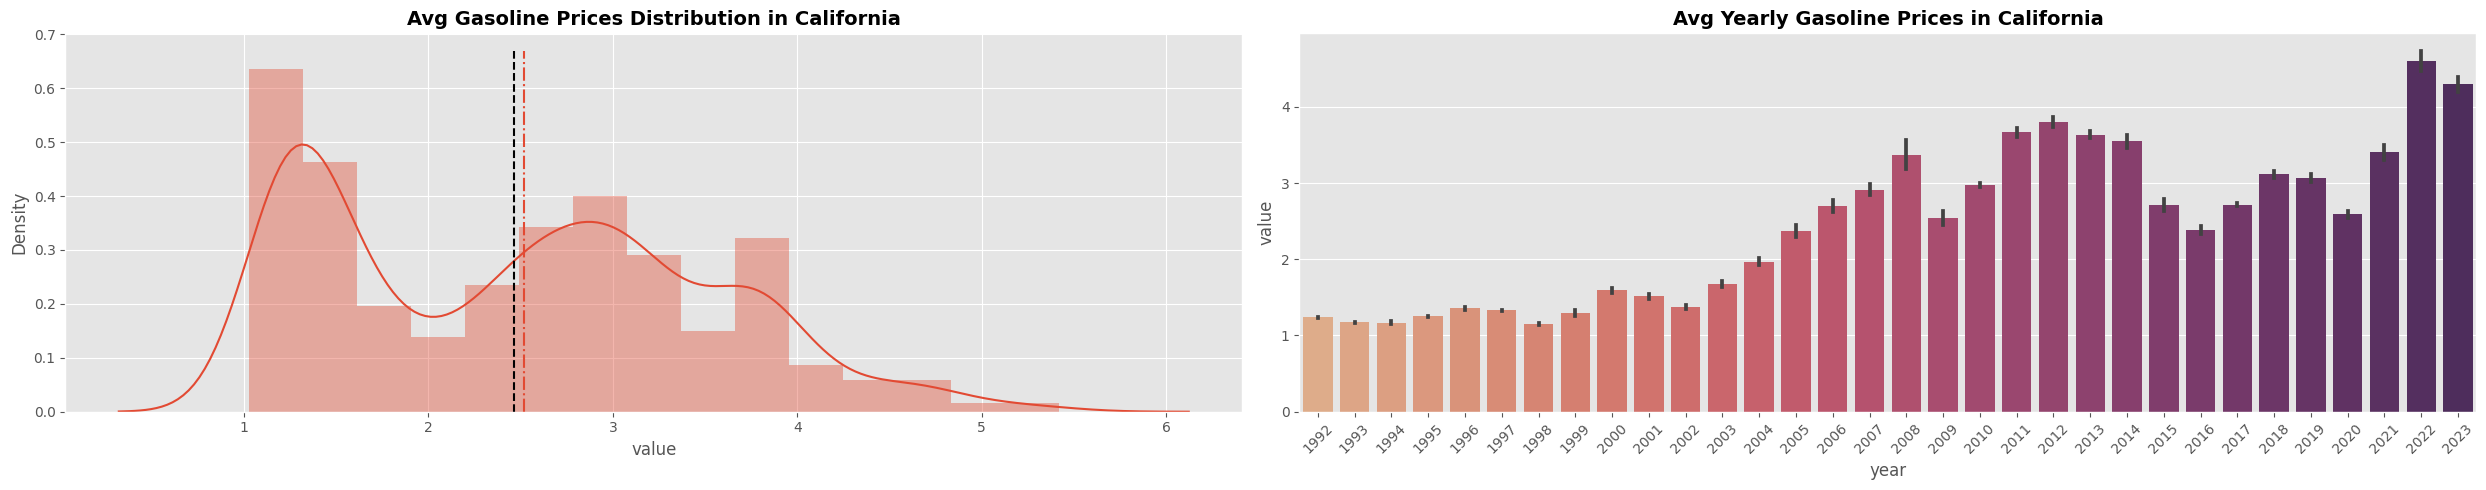

In [194]:
fig = plt.figure(figsize=(25,5)) 
ax = fig.add_subplot(1,2,1)

pricing: 'Series' = pricing_ca['value']
sns.distplot(pricing, ax=ax)
ymin,ymax = ax.get_ylim()
mean: float = pricing.mean()
median: float = pricing.median()
ax.vlines(mean, ymin=ymin, ymax=ymax, linestyle='--', label=f"Mean: {mean:.2f}", color='black' ) 
ax.vlines(median, ymin=ymin, ymax=ymax, linestyle='-.', label=f"Median: {mean:.2f}" ) 
ax.set_title("Avg Gasoline Prices Distribution in California", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
sns.barplot(data=pricing_ca, x='year', y='value' , palette='flare', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Avg Yearly Gasoline Prices in California", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Actual Gasoline Prices in `California`**
- **Note**: Collected from various Gas Stations in `CA` state

In [136]:
query: str = """ 

WITH table_names AS (
    SELECT TOP 13 id,
           name 
    FROM sysobjects WHERE name NOT LIKE '%GET%' AND name NOT LIKE '%PK%' AND name NOT LIKE '%FK%'  AND name NOT LIKE '%DF%' ORDER BY crdate DESC
    )

SELECT 
    s2.name AS "table_name", 
    s.name AS "column_name"
    
FROM syscolumns s
JOIN table_names AS s2 ON s2.id = s.id
WHERE s2.name LIKE '%Price%' OR s2.name LIKE '%station%' OR s2.name LIKE '%Store%' 

"""
tbl_lookup: 'DataFrame' = pd.read_sql(query, con=con )

In [149]:
query: str = f"""
(SELECT 
    g.name,
    g.price_unit, 
    g.region, 
    g.state,
    g.pay_status,
    g.enterprise,
    sl.address,
    sl.latitude,
    sl.longitude, 
    sl.ratings_count, 
    sl.star_rating,
    sl.zip_code,
    sl.country,
    cp.posted_time AS "timestamp",
    cp.price

FROM {tbl1} g 
JOIN {tbl2} sl ON sl.gasstation_id = g.gasstation_id
JOIN {tbl3} cp ON cp.store_id = sl.store_id
WHERE sl.region = 'CA')

UNION ALL 
(SELECT 
    g.name,
    g.price_unit, 
    g.region, 
    g.state,
    g.pay_status,
    g.enterprise,
    sl.address,
    sl.latitude,
    sl.longitude, 
    sl.ratings_count, 
    sl.star_rating,
    sl.zip_code,
    sl.country,
    cp.posted_time AS "timestamp",
    cp.price

FROM {tbl1} g 
JOIN {tbl2} sl ON sl.gasstation_id = g.gasstation_id
JOIN {tbl4} cp ON cp.store_id = sl.store_id
WHERE sl.region = 'CA')

"""

tbl1, tbl2, tbl3, tbl4 = (tbl_lookup['table_name'].unique().tolist()[:2] + tbl_lookup['table_name'].unique().tolist()[-2:])[-1::-1]
ca_pricing: 'DataFrame' = pd.read_sql(query, con=con) 
ca_pricing['month'] = ca_pricing['timestamp'].apply(lambda row: row.month) 
ca_pricing['month_name'] = ca_pricing['timestamp'].apply(lambda row: row.month_name()) 
ca_pricing['transc_date'] = ca_pricing['timestamp'].apply(lambda row: pd.to_datetime( '%s-%s-%s' % (row.year, row.month, row.day) ) )
ca_pricing = ca_pricing.drop_duplicates(['timestamp', 'address', 'latitude','longitude'])

In [156]:
ca_pricing.head()

,name,price_unit,region,state,pay_status,enterprise,address,latitude,longitude,ratings_count,star_rating,zip_code,country,timestamp,price,month,month_name,transc_date
0,Shell,dollars_per_gallon,Sterling,Alaska,0,0,2110 Eureka Way,40.586932,-122.402093,30,4,96001,US,2023-08-11 17:41:21.030,3.99,8,August,2023-08-11
1,Mono Winds Casino Fuel,dollars_per_gallon,Auberry,California,1,0,37302 Rancheria Ln,37.083564,-119.464517,45,4,93602,US,2023-08-12 00:49:48.357,4.22,8,August,2023-08-12
2,Yokut Gas Station,dollars_per_gallon,Lemoore,California,1,1,17051 Jersey Ave,36.239609,-119.763358,558,4,93245,US,2023-08-12 01:05:38.797,4.29,8,August,2023-08-12
3,Red Earth Casino,dollars_per_gallon,Salton Sea Beach,California,1,0,3089 Norm Niver Rd,33.352776,-116.01911,167,4,92275-6550,US,2023-08-11 22:19:07.877,4.29,8,August,2023-08-11
4,Shell,dollars_per_gallon,Sterling,Alaska,0,0,7741 Auburn Blvd,38.70709689231,-121.290677458044,106,3,95610-2125,US,2023-08-11 10:41:22.977,4.44,8,August,2023-08-11


## **Weekly Avg Gasoline Price in CA According to GasBuddy (Left and) EIA (Right)** 

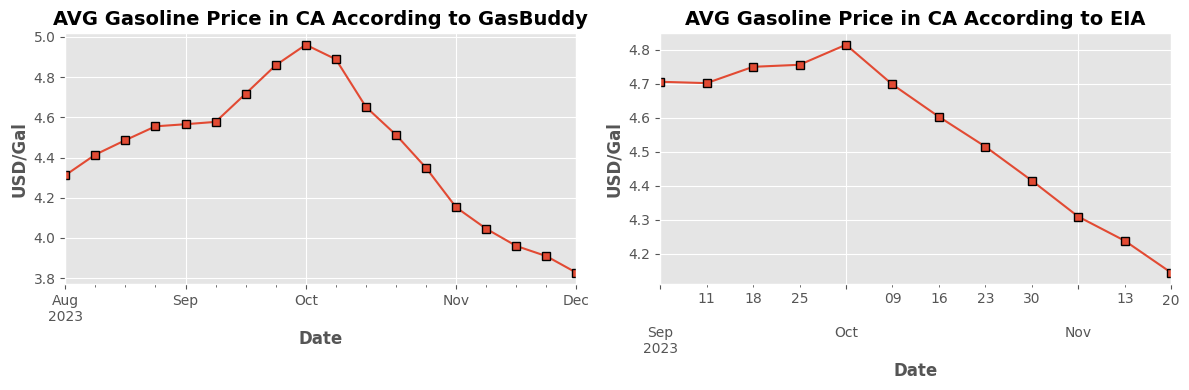

In [177]:
fig = plt.figure(figsize=(12,4) ) 
ax = fig.add_subplot(1,2,1)
ca_pricing.groupby("transc_date")['price'].mean().resample('W').mean().plot(ax=ax, marker='s', mec='black') 
ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("USD/Gal", fontweight='bold')
ax.set_title("AVG Gasoline Price in CA According to GasBuddy", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
pricing_ca.query("year >= 2023 and ( month > 8 and month < 12 )").set_index('period')['value'].plot(ax=ax, marker='s', mec='black') 
ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("USD/Gal", fontweight='bold')
ax.set_title("AVG Gasoline Price in CA According to EIA", fontweight='bold', fontsize=14)

plt.tight_layout() 